In [28]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, hour, when
from pyspark.ml.feature import VectorAssembler
from xgboost.spark import SparkXGBRegressor
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 🚀 Start Spark session
spark = SparkSession.builder.appName("PizzaPriceXGBoost").getOrCreate()

# 📂 Load CSV files
orders = spark.read.csv("Sales Data/orders.csv", header=True, inferSchema=True)
order_details = spark.read.csv("Sales Data/order_details.csv", header=True, inferSchema=True)
pizzas = spark.read.csv("Sales Data/pizzas.csv", header=True, inferSchema=True)
pizza_types = spark.read.csv("Sales Data/pizza_types.csv", header=True, inferSchema=True)

# 🛠 Check schema before joining
orders.printSchema()
order_details.printSchema()
pizzas.printSchema()
pizza_types.printSchema()

# 🔗 Join tables
df = orders.join(order_details, "order_id", "inner") \
           .join(pizzas, "pizza_id", "inner") \
           .join(pizza_types, "pizza_type_id", "inner") \
           .select("size", "category", "time", "quantity", "price")

# 🕒 Convert time column to timestamp and extract order hour
df = df.withColumn("time", col("time").cast("timestamp"))
df = df.withColumn("order_hour", hour(col("time")))

# 💰 Define revenue
df = df.withColumn("revenue", col("quantity") * col("price"))

# 🔹 One-hot encoding for categorical variables
df = df.withColumn("is_large", when(col("size") == "L", 1).otherwise(0)) \
       .withColumn("is_medium", when(col("size") == "M", 1).otherwise(0)) \
       .withColumn("is_small", when(col("size") == "S", 1).otherwise(0)) \
       .withColumn("is_veggie", when(col("category") == "Vegetarian", 1).otherwise(0)) \
       .withColumn("is_meat", when(col("category") == "Meat", 1).otherwise(0))


root
 |-- order_id: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- time: timestamp (nullable = true)

root
 |-- order_details_id: integer (nullable = true)
 |-- order_id: integer (nullable = true)
 |-- pizza_id: string (nullable = true)
 |-- quantity: integer (nullable = true)

root
 |-- pizza_id: string (nullable = true)
 |-- pizza_type_id: string (nullable = true)
 |-- size: string (nullable = true)
 |-- price: double (nullable = true)

root
 |-- pizza_type_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- category: string (nullable = true)
 |-- ingredients: string (nullable = true)



In [29]:
df.columns

['size',
 'category',
 'time',
 'quantity',
 'price',
 'order_hour',
 'revenue',
 'is_large',
 'is_medium',
 'is_small',
 'is_veggie',
 'is_meat']

In [30]:

# 🎯 Prepare features
features = ["order_hour", "quantity", "price", "is_large", "is_medium", "is_small", "is_veggie", "is_meat"]
assembler = VectorAssembler(inputCols=features, outputCol="features")
df = assembler.transform(df).select("features", "revenue")

# 🛠 Handle missing values
#df = df.fillna({"quantity": 0, "price": 0, "order_hour": 0})

# 🔥 Split data
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)



In [31]:
# 📈 Train XGBoost model
xgb = SparkXGBRegressor(features_col="features", label_col="revenue", max_depth=6, eta=0.1, objective="reg:squarederror")
xgb_model = xgb.fit(train_data)

# 🎯 Make predictions
predictions = xgb_model.transform(test_data)
predictions.select("revenue", "prediction").show(10)

# 📊 Evaluate model
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="revenue", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

print(f"🚀 RMSE: {rmse:.2f}")

# 🔍 Feature Importance
feature_importance = xgb_model.get_booster().get_score(importance_type="weight")

# 🛠 Ensure correct data types
if not isinstance(feature_importance, dict):
    feature_importance = {}

# 🔹 Map feature indices to names
feature_names = assembler.getInputCols()
feature_importance_df = pd.DataFrame({
    "Feature": feature_names[:len(feature_importance)],
    "Importance": list(feature_importance.values())
})


2025-02-19 00:50:37,211 INFO XGBoost-PySpark: _fit Running xgboost-2.1.4 on 1 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'max_depth': 6, 'eta': 0.1, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-02-19 00:50:39,059 INFO XGBoost-PySpark: _train_booster Training on CPUs 1]
[00:50:40] Task 0 got rank 0
2025-02-19 00:50:41,301 INFO XGBoost-PySpark: _fit Finished xgboost training!   
2025-02-19 00:50:41,741 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


+-------+----------------+
|revenue|      prediction|
+-------+----------------+
|   25.5|25.4996280670166|
|   25.5|25.4996280670166|
|   25.5|25.4996280670166|
|   25.5|25.4996280670166|
|   25.5|25.4996280670166|
|   25.5|25.4996280670166|
|   25.5|25.4996280670166|
|   25.5|25.4996280670166|
|   25.5|25.4996280670166|
|   25.5|25.4996280670166|
+-------+----------------+
only showing top 10 rows



🚀 RMSE: 0.00


2025-02-19 00:50:43,861 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


/tmp/ipykernel_439648/2611332160.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/home/tknyshenko/graice-installs/graice/.venv/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/tknyshenko/graice-installs/graice/.venv/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/tknyshenko/graice-installs/graice/.venv/lib/python3.11/site-packages/seabor

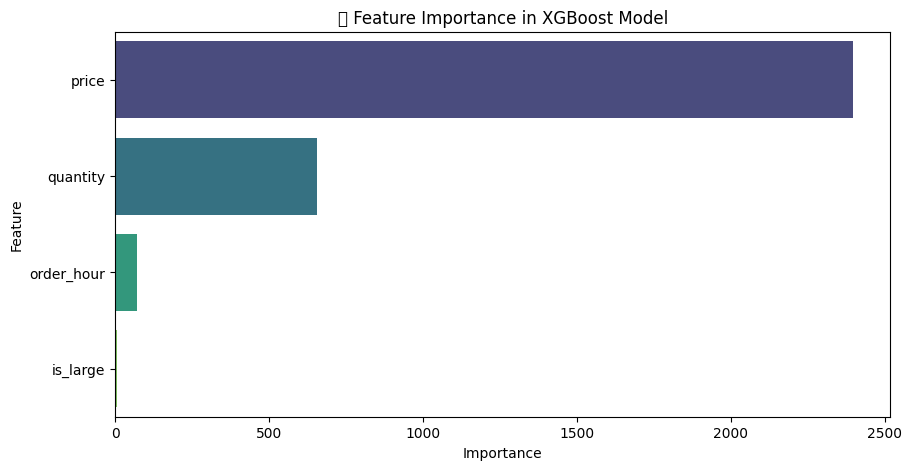

In [32]:
# 📊 Plot feature importance
plt.figure(figsize=(10, 5))
sns.barplot(
    x="Importance",
    y="Feature",
    data=feature_importance_df.sort_values(by="Importance", ascending=False),
    palette="viridis"
)
plt.title("🔹 Feature Importance in XGBoost Model")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()